In [ ]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 28.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import gdown
import gensim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsRegressor
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import torch
import emoji

In [ ]:
dataset_url = "https://drive.google.com/file/d/1nRYbdnsrgJKu6Zvfry7LIxCX-mGQzYTI/view?usp=sharing"
emoji2vec_url = "https://drive.google.com/file/d/1cECoRBfhSJ0sWY0_6I037hsrtxfSyzNa/view?usp=sharing"

output_dataset = "train.csv"
emoji2vec_file = "emoji2vec.txt"

gdown.download(dataset_url, output=output_dataset, quiet=False, fuzzy=True)
gdown.download(emoji2vec_url, output=emoji2vec_file, quiet=False, fuzzy=True)

df = pd.read_csv(output_dataset, encoding='utf-8')

chinese_indices = df[df['language'] == 'Chinese'].index
df.drop(chinese_indices, inplace=True)

Downloading...
From: https://drive.google.com/uc?id=1nRYbdnsrgJKu6Zvfry7LIxCX-mGQzYTI
To: /content/train.csv
100%|██████████| 813k/813k [00:00<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cECoRBfhSJ0sWY0_6I037hsrtxfSyzNa
To: /content/emoji2vec.txt
100%|██████████| 9.78M/9.78M [00:00<00:00, 24.2MB/s]


In [ ]:
print(df['language'].unique())
df.shape

['English' 'Spanish' 'Portuguese' 'Italian' 'French']


(7895, 3)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

stopwords_dict = {
    "en": stopwords.words("english"),
    "fr": stopwords.words("french"),
    "it": stopwords.words("italian"),
    "pt": stopwords.words("portuguese"),
    "es": stopwords.words("spanish"),
}

def clean_text(text, lang):
    text = text.lower()
    text = re.sub(r'http\S+|https\S+|http|https', '', text)
    text = re.sub(r'@\w+', '', text)
    allowed_symbols = set("+-=")
    text = ''.join(char if char.isalnum() or char.isspace() or char in allowed_symbols or emoji.is_emoji(char) else '' for char in text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords_dict.get(lang, [])]
    return ' '.join(tokens)

df['cleaned_text'] = df.apply(lambda row: clean_text(row['text'], row['language']), axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df.head()

,text,label,language,cleaned_text
0,wearing a fake engagement ring so guys won’t a...,1.8,English,wearing a fake engagement ring so guys wont ap...
1,Bees vs. Wasps. http,1.0,English,bees vs wasps
2,Here is a nice equation: 0+0-0-0+0=0,1.0,English,here is a nice equation 0+0-0-0+0=0
3,@user @user Enjoy each new day!😊🇨🇦🐞🐭,1.6,English,enjoy each new day😊🐞🐭
4,I can be having a perfectly good day then I th...,1.6,English,i can be having a perfectly good day then i th...


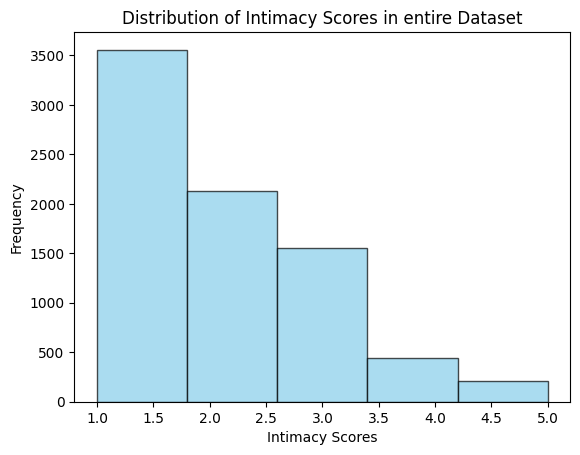

In [ ]:
plt.hist(df['label'], bins=5, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Intimacy Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Intimacy Scores in entire Dataset')
plt.show()

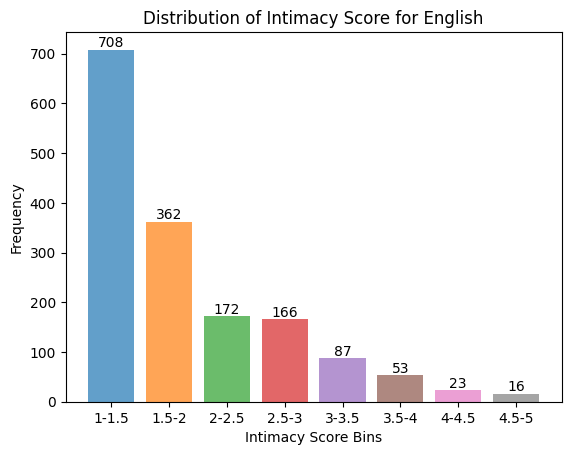

Exact counts for intimacy score in English:
  1-1.5: 708
  1.5-2: 362
  2-2.5: 172
  2.5-3: 166
  3-3.5: 87
  3.5-4: 53
  4-4.5: 23
  4.5-5: 16




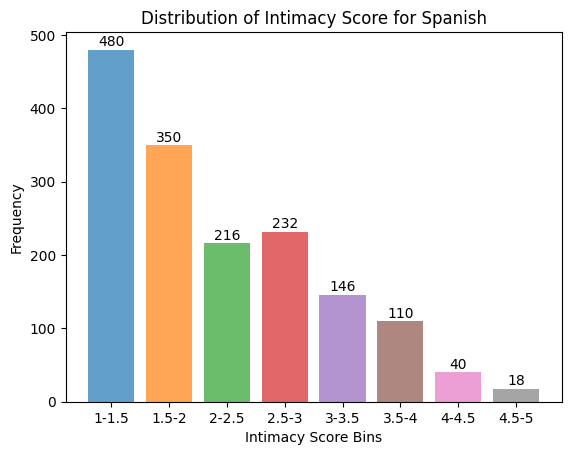

Exact counts for intimacy score in Spanish:
  1-1.5: 480
  1.5-2: 350
  2-2.5: 216
  2.5-3: 232
  3-3.5: 146
  3.5-4: 110
  4-4.5: 40
  4.5-5: 18




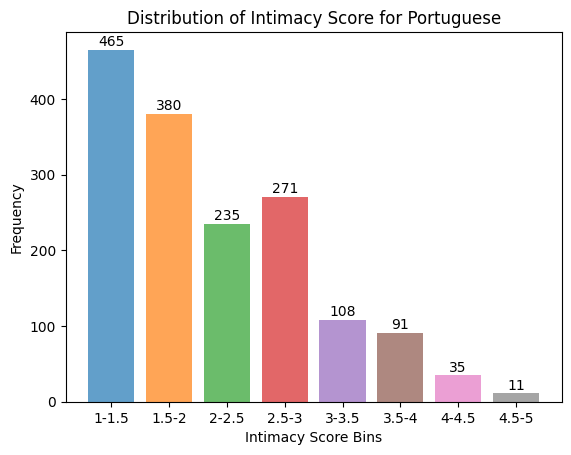

Exact counts for intimacy score in Portuguese:
  1-1.5: 465
  1.5-2: 380
  2-2.5: 235
  2.5-3: 271
  3-3.5: 108
  3.5-4: 91
  4-4.5: 35
  4.5-5: 11




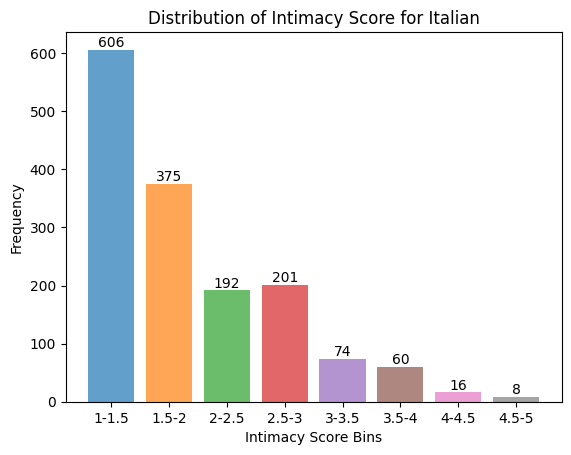

Exact counts for intimacy score in Italian:
  1-1.5: 606
  1.5-2: 375
  2-2.5: 192
  2.5-3: 201
  3-3.5: 74
  3.5-4: 60
  4-4.5: 16
  4.5-5: 8




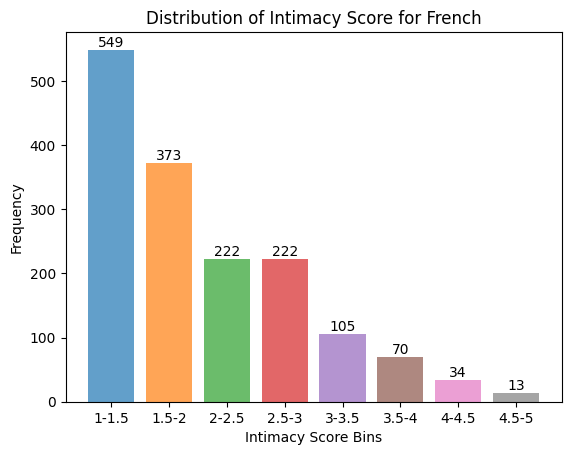

Exact counts for intimacy score in French:
  1-1.5: 549
  1.5-2: 373
  2-2.5: 222
  2.5-3: 222
  3-3.5: 105
  3.5-4: 70
  4-4.5: 34
  4.5-5: 13


In [ ]:
bins = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
labels = ["1-1.5", "1.5-2", "2-2.5", "2.5-3", "3-3.5", "3.5-4", "4-4.5", "4.5-5"]

df['score_bin'] = pd.cut(df['label'], bins=bins, labels=labels, include_lowest=True)

languages = df['language'].unique()

for lang in languages:
    print("\n")
    lang_df = df[df['language'] == lang]
    group_counts = lang_df['score_bin'].value_counts().sort_index()

    plt.bar(group_counts.index, group_counts.values, color=plt.cm.tab10.colors[:len(group_counts)], alpha=0.7)
    plt.xlabel('Intimacy Score Bins')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Intimacy Score for {lang}')

    for i, count in enumerate(group_counts.values):
        plt.text(i, count + 5, str(count), ha='center', fontsize=10)

    plt.show()

    print(f"Exact counts for intimacy score in {lang}:")
    for group, count in group_counts.items():
        print(f"  {group}: {count}")

In [ ]:
emoji_embeddings = {}
with open(emoji2vec_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) > 1:
            emoji_char = parts[0]
            vector = np.array(parts[1:], dtype=float)
            emoji_embeddings[emoji_char] = vector

def extract_emojis(text):
    return [char for char in text if char in emoji_embeddings]

def get_emoji_embedding(emoji_list):
    if not emoji_list:
        return np.zeros(300)
    vectors = [emoji_embeddings[em] for em in emoji_list]
    return np.mean(vectors, axis=0)

df['emoji_embedding'] = df['text'].apply(lambda x: get_emoji_embedding(extract_emojis(x)))

In [ ]:
sentences = df['cleaned_text'].str.split()
word2vec_model = gensim.models.Word2Vec(sentences, vector_size=300, window=5, min_count=2, workers=4)

def get_word2vec_embedding(text):
    tokens = text.split()
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if not vectors:
        return np.zeros(300)
    return np.mean(vectors, axis=0)

df['word2vec_embedding'] = df['cleaned_text'].apply(get_word2vec_embedding)

In [ ]:
df['combined_embedding'] = df.apply(
    lambda row: np.hstack([row['word2vec_embedding'], row['emoji_embedding']]), axis=1
)

In [ ]:
def oversample_with_knn(X, y, n_neighbors=5, n_samples=1000, random_state=42):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(X, y)

    np.random.seed(random_state)
    indices = np.random.choice(len(X), n_samples)
    X_synthetic = X[indices] + np.random.normal(scale=0.01, size=X[indices].shape)
    y_synthetic = knn.predict(X_synthetic)

    X_resampled = np.vstack([X, X_synthetic])
    y_resampled = np.hstack([y, y_synthetic])

    return X_resampled, y_resampled

In [ ]:
def visualize_pearson(results, model_name):
    languages = list(results.keys())
    scores = list(results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(languages, scores, color='skyblue')
    plt.xlabel('Languages')
    plt.ylabel("Pearson's r")
    plt.title(f"Pearson's r for {model_name} by Language")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def random_forest(df):
    results = {}
    for lang in df['language'].unique():
        print("\n")
        print(f"Evaluating Random Forest for language: {lang}")

        lang_df = df[df['language'] == lang]
        X = np.vstack(lang_df['combined_embedding'])
        y = lang_df['label']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_resampled, y_train_resampled = oversample_with_knn(X_train, y_train, n_samples=500)

        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train_resampled, y_train_resampled)

        y_pred = rf_model.predict(X_test)
        pearson_r = pearsonr(y_test, y_pred)[0]
        results[lang] = pearson_r

        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.title(f"Random Forest Predictions vs Actual: {lang}")
        plt.xlabel("Actual Intimacy Scores")
        plt.ylabel("Predicted Intimacy Scores")
        plt.show()

    avg_pearson = np.mean(list(results.values()))
    print(f"Average Pearson's r for Random Forest: {avg_pearson}")
    visualize_pearson(results, "Random Forest")
    return results, avg_pearson

In [ ]:
class RegressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

In [ ]:
import torch.nn as nn
class TransformerWithFFNN(nn.Module):
    def __init__(self, model_name, ff_hidden_size):
        super(TransformerWithFFNN, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.ffnn = nn.Sequential(
            nn.Linear(self.transformer.config.hidden_size, ff_hidden_size),
            nn.ReLU(),
            nn.Linear(ff_hidden_size, 1)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0, :]
        logits = self.ffnn(hidden_state)
        loss = None
        if labels is not None:
            loss_fn = nn.MSELoss()
            loss = loss_fn(logits.squeeze(), labels)
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}


In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs["logits"]

        loss_fn = torch.nn.MSELoss(reduction="none")
        loss = loss_fn(logits.squeeze(), labels)

        weighted_loss = loss.mean()

        return (weighted_loss, outputs) if return_outputs else weighted_loss


In [ ]:
from torch.utils.data import Dataset
class RegressionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel

class TransformerWithFFNN(nn.Module):
    def __init__(self, model_name, ff_hidden_size):
        super(TransformerWithFFNN, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.ffnn = nn.Sequential(
            nn.Linear(self.transformer.config.hidden_size, ff_hidden_size),
            nn.ReLU(),
            nn.Linear(ff_hidden_size, 1)
        )

    def mean_pooling(self, hidden_states, attention_mask):
        mask = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
        sum_hidden = torch.sum(hidden_states * mask, dim=1)
        sum_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
        return sum_hidden / sum_mask

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        pooled_output = self.mean_pooling(hidden_state, attention_mask)
        logits = self.ffnn(pooled_output)
        loss = None
        if labels is not None:
            loss_fn = nn.MSELoss()
            loss = loss_fn(logits.squeeze(), labels)
        return (loss, logits) if loss is not None else logits


In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

def transformer_with_ffnn(df, model_name, ff_hidden_size=768):
    results = {}
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    for lang in df['language'].unique():
        print(f"\nEvaluating {model_name} with FFNN for language: {lang}")

        lang_df = df[df['language'] == lang]
        lang_train, lang_test = train_test_split(lang_df, test_size=0.2, random_state=42)

        train_encodings = tokenizer(list(lang_train['text']), truncation=True, padding=True, return_tensors="pt")
        test_encodings = tokenizer(list(lang_test['text']), truncation=True, padding=True, return_tensors="pt")

        train_dataset = RegressionDataset(train_encodings, lang_train['label'].values)
        test_dataset = RegressionDataset(test_encodings, lang_test['label'].values)

        model = TransformerWithFFNN(model_name, ff_hidden_size)

        args = TrainingArguments(
            output_dir=f"./results_{lang}",
            evaluation_strategy="epoch",
            logging_strategy="steps",
            logging_steps=50,
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            num_train_epochs=4,
            weight_decay=0.01,
            save_steps=10_000,
            save_total_limit=2,
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            tokenizer=tokenizer
        )

        trainer.train()

        predictions = trainer.predict(test_dataset)
        predicted_labels = predictions.predictions.squeeze()

        pearson_r = pearsonr(lang_test['label'], predicted_labels)[0]
        results[lang] = pearson_r

        plt.figure(figsize=(8, 6))
        plt.scatter(lang_test['label'], predicted_labels, alpha=0.5)
        plt.title(f"{model_name} with FFNN Predictions vs Actual: {lang}")
        plt.xlabel("Actual Intimacy Scores")
        plt.ylabel("Predicted Intimacy Scores")
        plt.show()

    avg_pearson = np.mean(list(results.values()))
    print(f"\nAverage Pearson's r for {model_name} with FFNN: {avg_pearson}")

    visualize_pearson(results, f"{model_name} with FFNN")

    return results, avg_pearson



Evaluating Random Forest for language: English


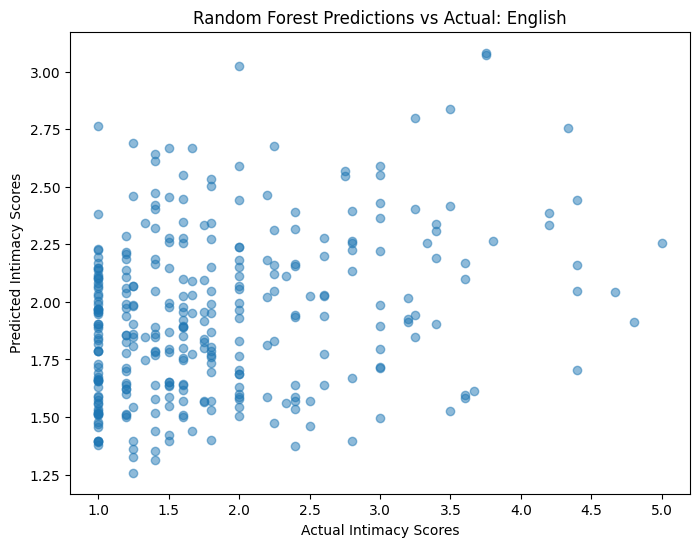



Evaluating Random Forest for language: Spanish


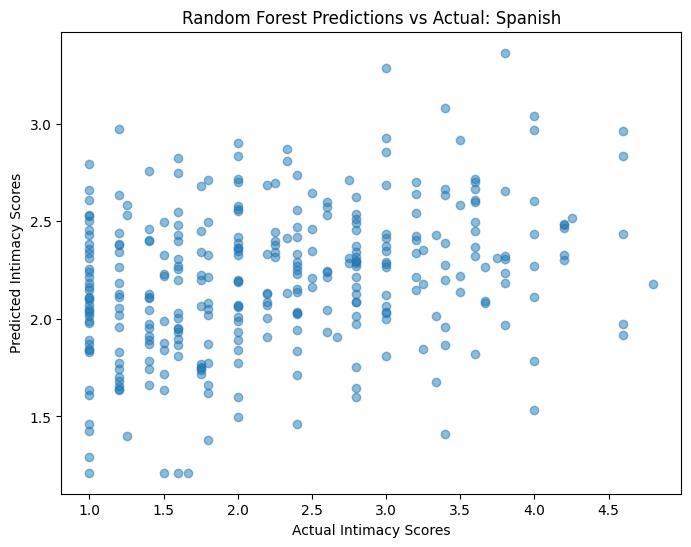



Evaluating Random Forest for language: Portuguese


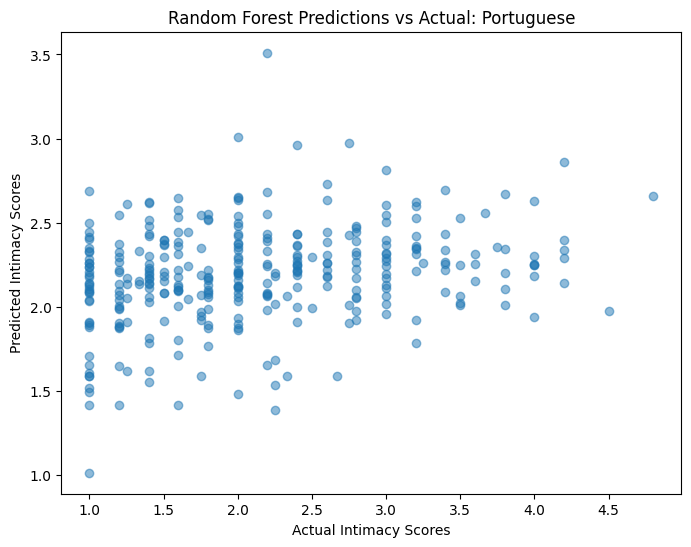



Evaluating Random Forest for language: Italian


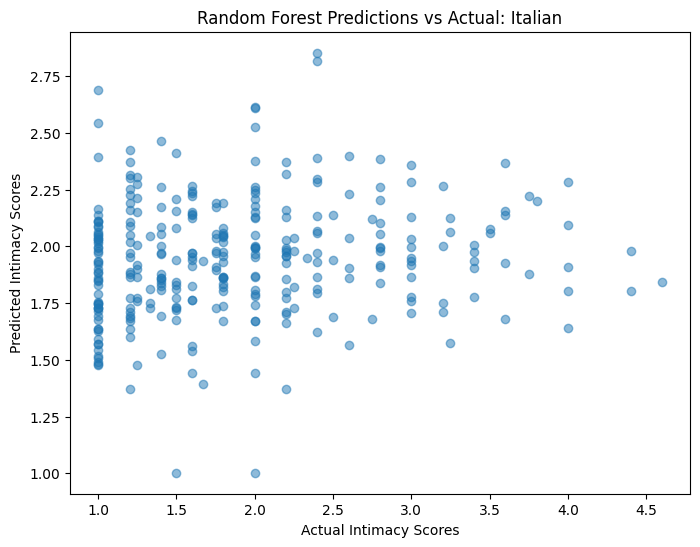



Evaluating Random Forest for language: French


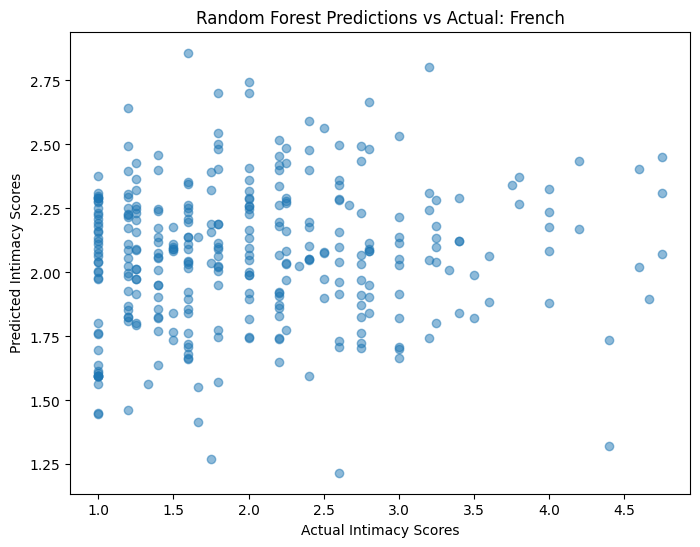

Average Pearson's r for Random Forest: 0.21528137733449046


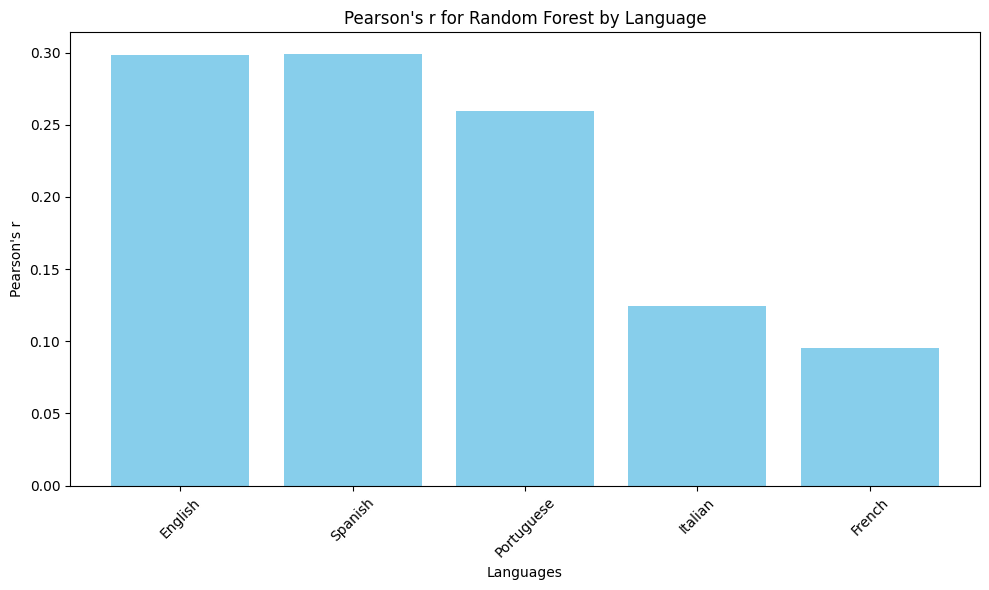

In [ ]:
rf_results, rf_avg = random_forest(df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Evaluating cardiffnlp/twitter-xlm-roberta-base with FFNN for language: English


pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Ple

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,1.228200,0.395888
2,0.362000,0.432205
3,0.252400,0.403075
4,0.190100,0.389008


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


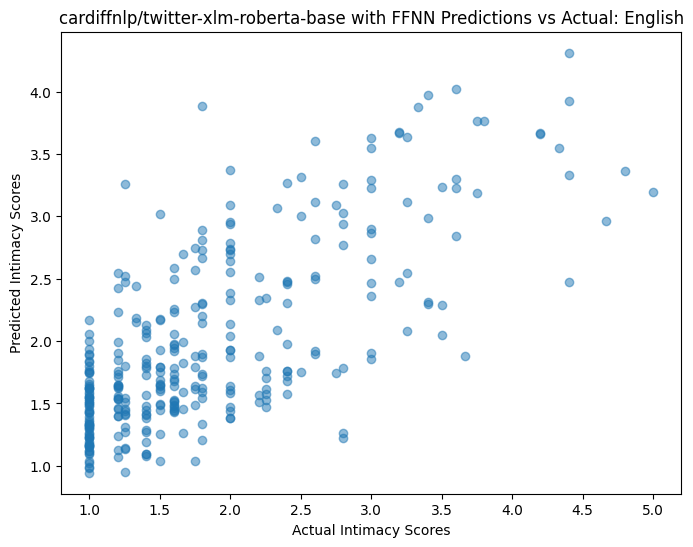


Evaluating cardiffnlp/twitter-xlm-roberta-base with FFNN for language: Spanish


Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[i

Epoch,Training Loss,Validation Loss
1,1.336500,0.494838
2,0.353400,0.439968
3,0.287000,0.441247
4,0.176000,0.444660


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


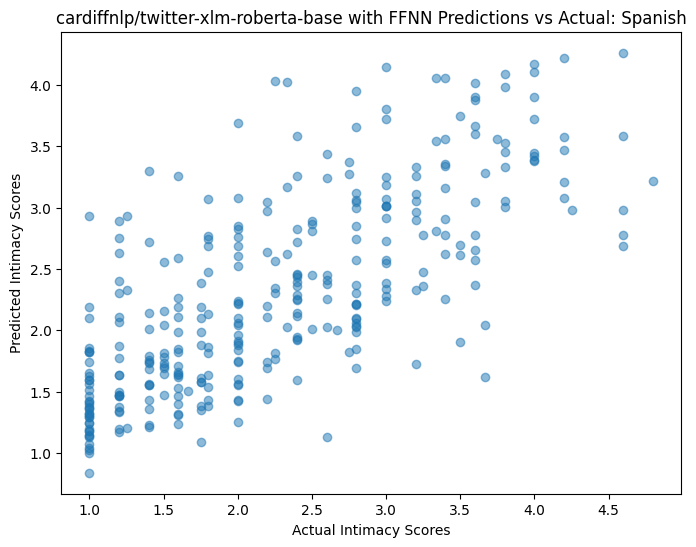


Evaluating cardiffnlp/twitter-xlm-roberta-base with FFNN for language: Portuguese


Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[i

Epoch,Training Loss,Validation Loss
1,1.316000,0.667861
2,0.408500,0.495804
3,0.286400,0.489047
4,0.201100,0.432121


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


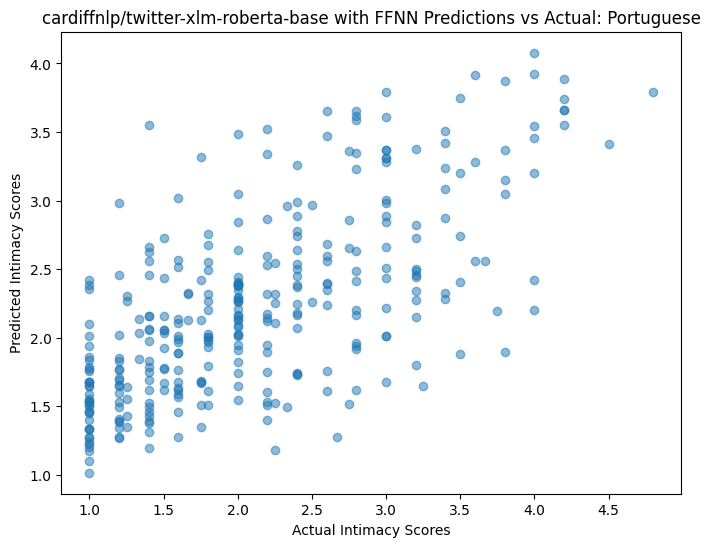


Evaluating cardiffnlp/twitter-xlm-roberta-base with FFNN for language: Italian


Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[i

Epoch,Training Loss,Validation Loss
1,1.264800,0.460314
2,0.441700,0.409109
3,0.344400,0.461366
4,0.251300,0.471915


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


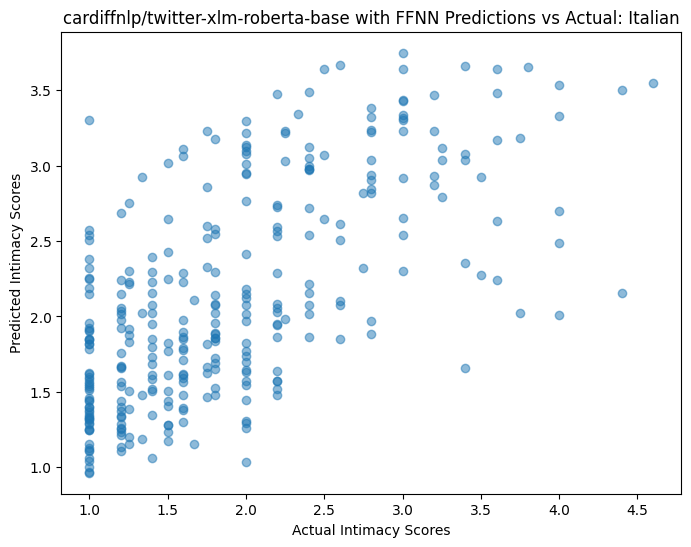


Evaluating cardiffnlp/twitter-xlm-roberta-base with FFNN for language: French


Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[i

Epoch,Training Loss,Validation Loss
1,1.136700,0.513718
2,0.426300,0.521887
3,0.317800,0.500384
4,0.214200,0.518844


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


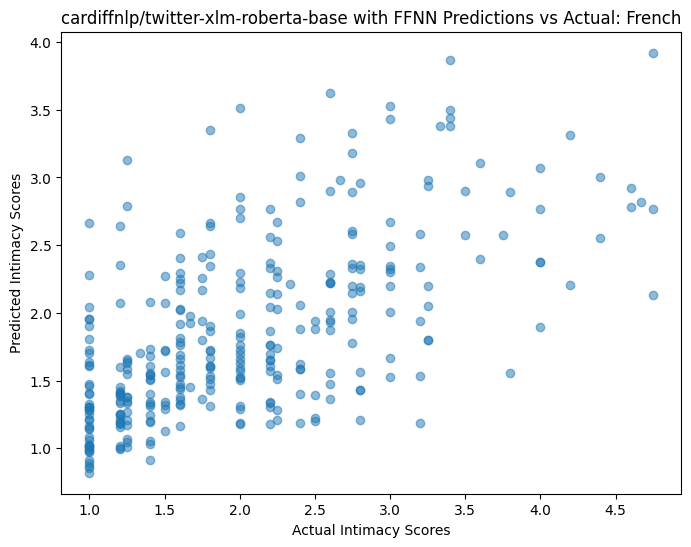


Average Pearson's r for cardiffnlp/twitter-xlm-roberta-base with FFNN: 0.6777727427718354


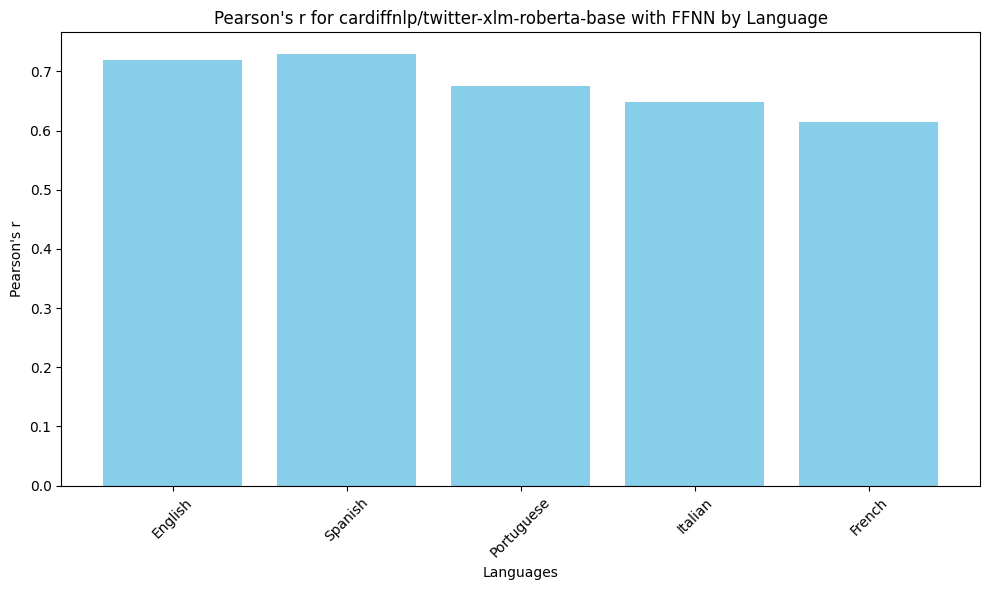

In [ ]:
from transformers import AutoModel, AutoTokenizer
xlmt_results, xlmt_avg = transformer_with_ffnn(df, "cardiffnlp/twitter-xlm-roberta-base", 768)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]


Evaluating xlm-roberta-base with FFNN for language: English


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,1.238000,0.508510
2,0.546400,0.602397
3,0.449600,0.509241
4,0.366800,0.475837


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


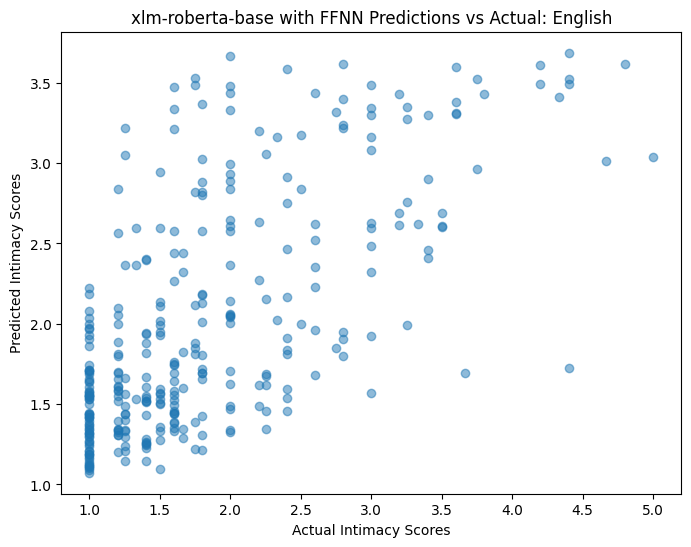


Evaluating xlm-roberta-base with FFNN for language: Spanish


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,1.458200,0.708114
2,0.631100,0.572820
3,0.587300,0.546744
4,0.457400,0.548435


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


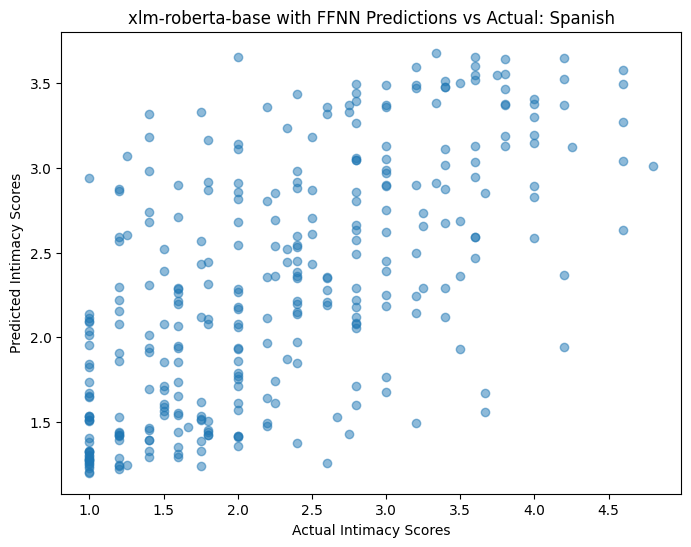


Evaluating xlm-roberta-base with FFNN for language: Portuguese


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,1.404200,0.763665
2,0.581500,0.799944
3,0.492300,0.557711
4,0.422800,0.499136


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


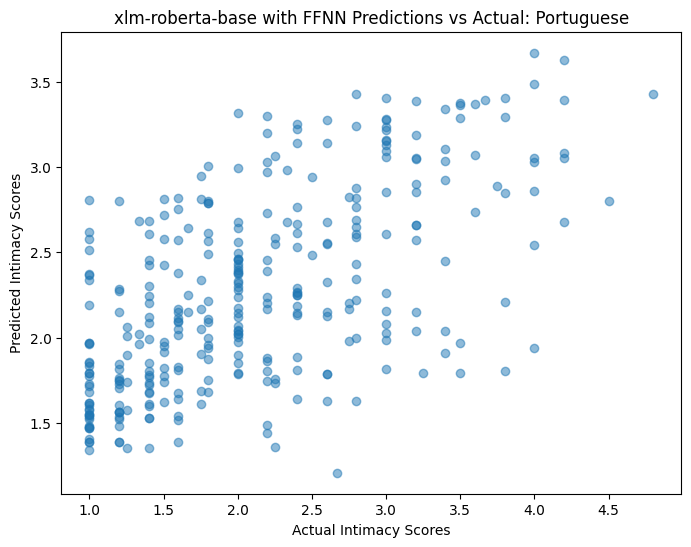


Evaluating xlm-roberta-base with FFNN for language: Italian


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,1.259900,0.531824
2,0.589100,0.434156
3,0.480200,0.567020
4,0.431100,0.535686


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


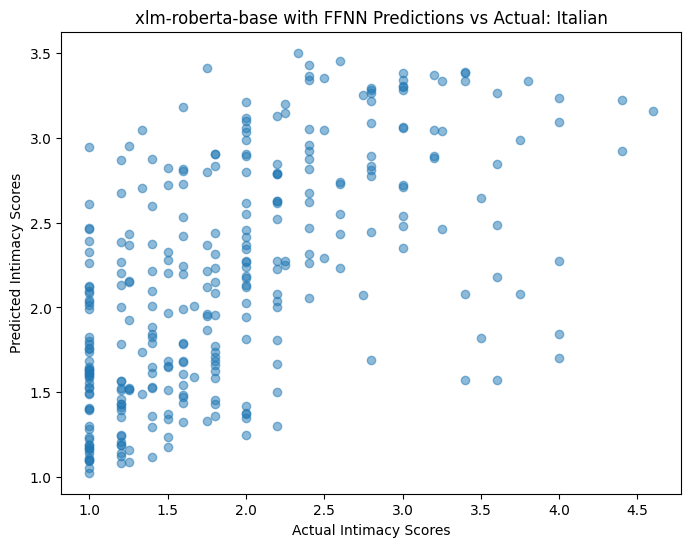


Evaluating xlm-roberta-base with FFNN for language: French


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,1.213100,0.713665
2,0.636700,0.607296
3,0.582200,0.636754
4,0.467500,0.565564


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


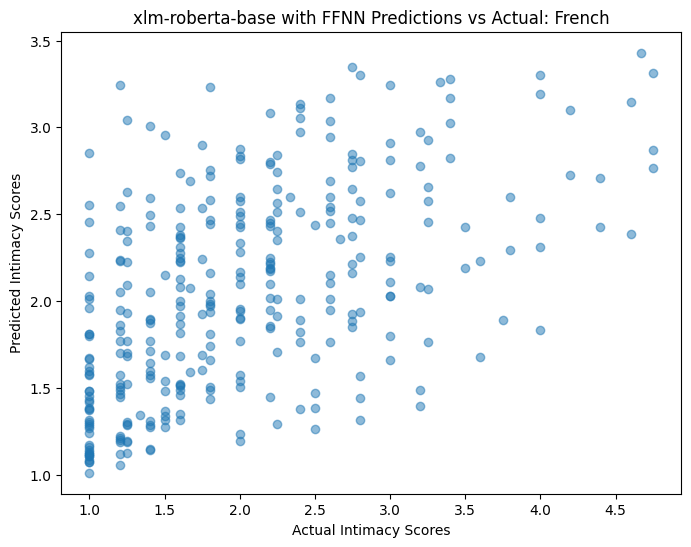


Average Pearson's r for xlm-roberta-base with FFNN: 0.6096476574382408


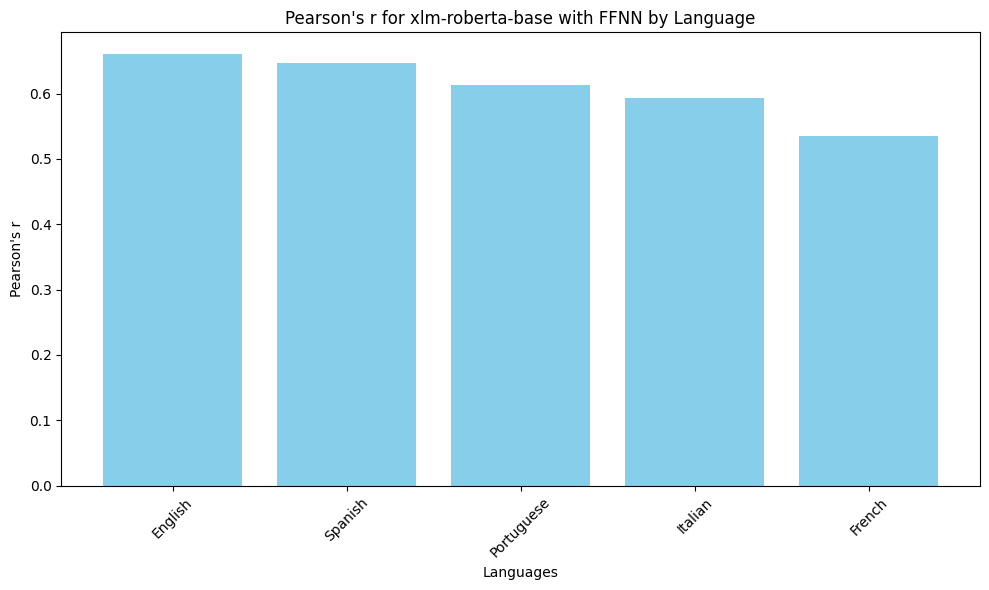

In [ ]:
xlmr_results, xlmr_avg = transformer_with_ffnn(df,"xlm-roberta-base", 768)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]


Evaluating bert-base-multilingual-cased with FFNN for language: English


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.856900,0.485508
2,0.508500,0.680011
3,0.375100,0.513283
4,0.245700,0.470685


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


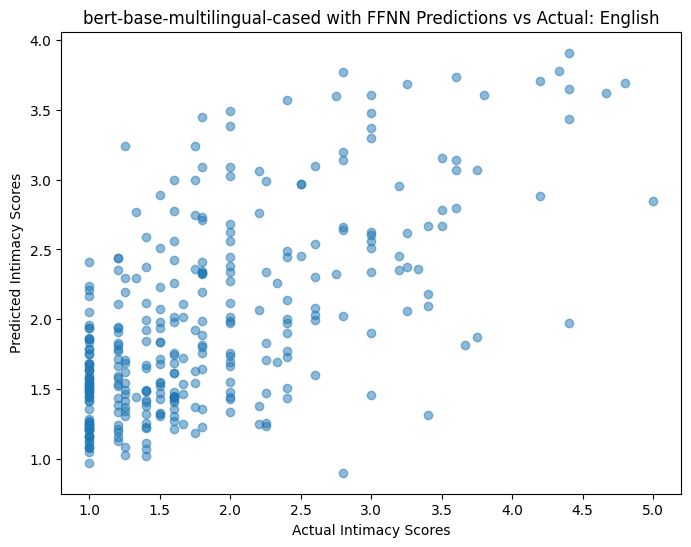


Evaluating bert-base-multilingual-cased with FFNN for language: Spanish


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.930300,0.637587
2,0.494600,0.579709
3,0.400000,0.604663
4,0.247200,0.612524


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


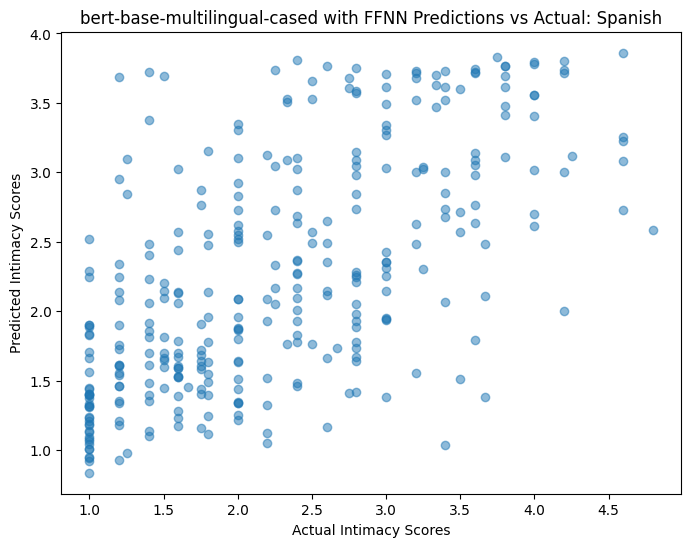


Evaluating bert-base-multilingual-cased with FFNN for language: Portuguese


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.864800,0.648413
2,0.523400,0.759521
3,0.401700,0.697786
4,0.271000,0.610458


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


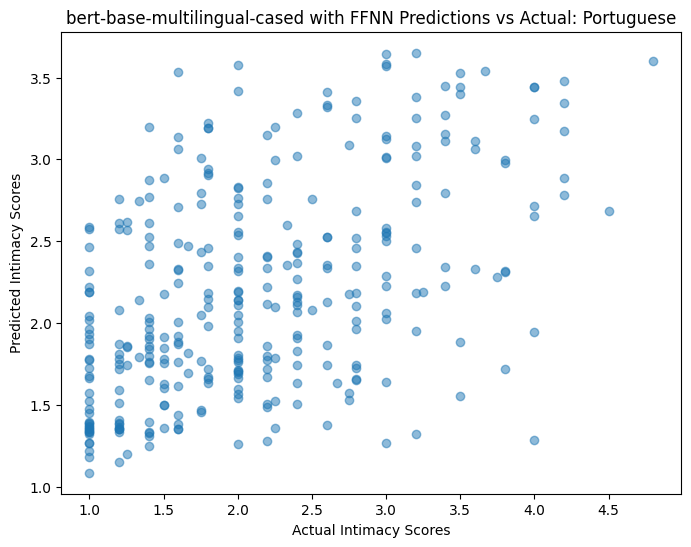


Evaluating bert-base-multilingual-cased with FFNN for language: Italian


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.902000,0.497995
2,0.461100,0.548737
3,0.356900,0.601979
4,0.234400,0.601279


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


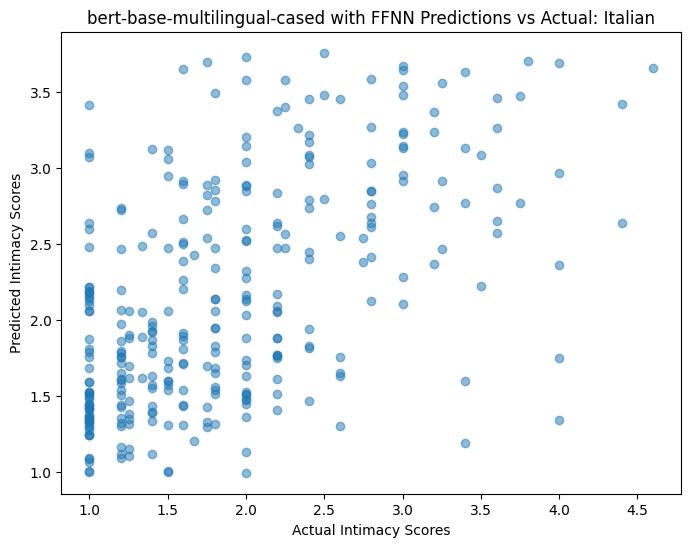


Evaluating bert-base-multilingual-cased with FFNN for language: French


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-021aef60e7a9>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.775400,0.698785
2,0.456100,0.544976
3,0.340300,0.650061
4,0.232500,0.589155


<ipython-input-19-6aa8dc6a7bd2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


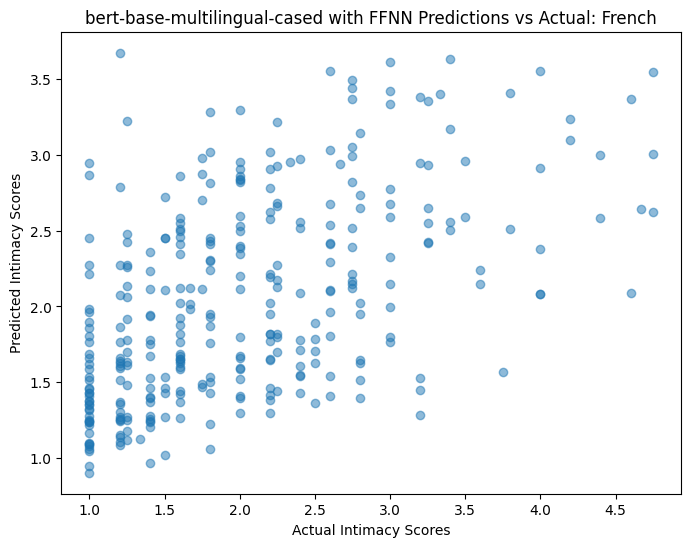


Average Pearson's r for bert-base-multilingual-cased with FFNN: 0.5732494422437585


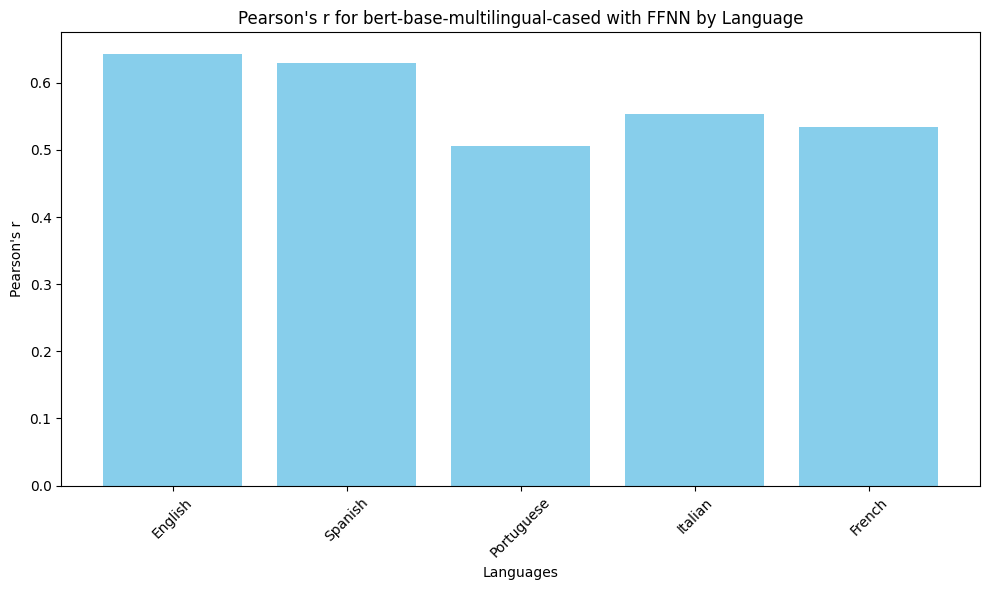

In [ ]:
mbert_results, mbert_avg = transformer_with_ffnn(df,"bert-base-multilingual-cased", 768)

In [ ]:
# Summary
print(f"\nRandom Forest Per-Language Pearson's r: {rf_results}")
print(f"XLM-T Per-Language Pearson's r: {xlmt_results}")
print(f"XLM-R Per-Language Pearson's r: {xlmr_results}")
print(f"mBERT Per-Language Pearson's r: {mbert_results}")

print(f"\nRandom Forest Average Pearson's r: {rf_avg:.4f}")
print(f"XLM-T Average Pearson's r: {xlmt_avg:.4f}")
print(f"XLM-R Average Pearson's r: {xlmr_avg:.4f}")
print(f"mBERT Average Pearson's r: {mbert_avg:.4f}")


Random Forest Per-Language Pearson's r: {'English': 0.2981068025514374, 'Spanish': 0.2991401578993445, 'Portuguese': 0.2592993023495186, 'Italian': 0.12437213234455428, 'French': 0.09548849152759749}
XLM-T Per-Language Pearson's r: {'English': 0.7200366502445605, 'Spanish': 0.7296959649398213, 'Portuguese': 0.6762070980569317, 'Italian': 0.6477698325515576, 'French': 0.615154168066306}
XLM-R Per-Language Pearson's r: {'English': 0.6607429705832555, 'Spanish': 0.6469133881510235, 'Portuguese': 0.6124325289141516, 'Italian': 0.5927952256017508, 'French': 0.5353541739410226}
mBERT Per-Language Pearson's r: {'English': 0.6430686812171158, 'Spanish': 0.629831940934578, 'Portuguese': 0.5060978400323444, 'Italian': 0.5528758502014592, 'French': 0.5343728988332956}

Random Forest Average Pearson's r: 0.2153
XLM-T Average Pearson's r: 0.6778
XLM-R Average Pearson's r: 0.6096
mBERT Average Pearson's r: 0.5732


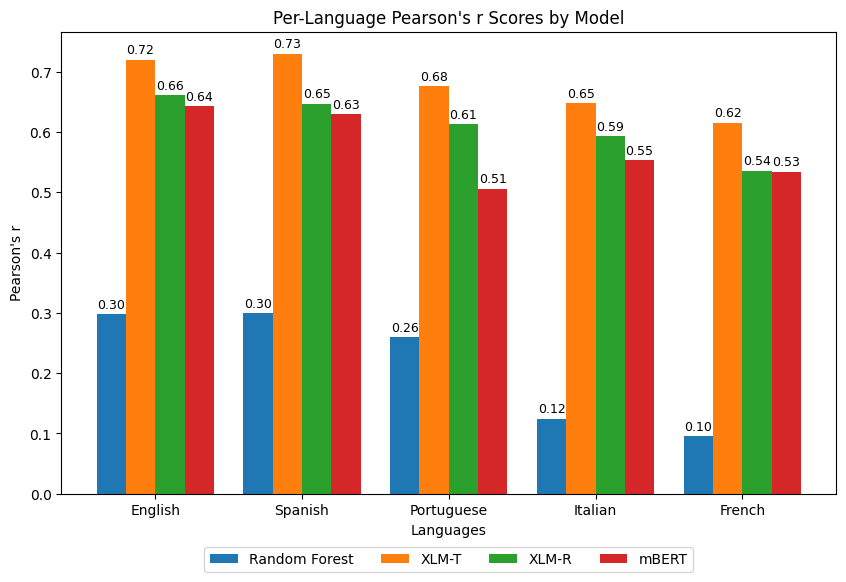

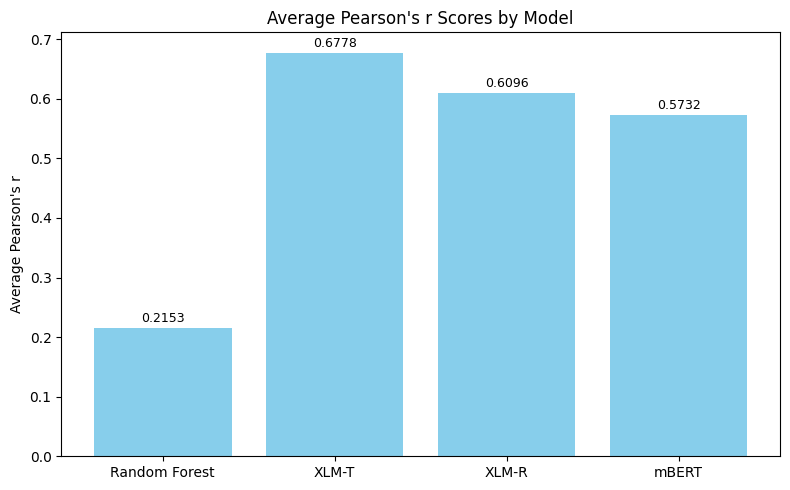

In [ ]:
x = np.arange(len(languages))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
bars = []
bars.append(ax.bar(x - 1.5 * width, list(rf_results.values()), width, label='Random Forest'))
bars.append(ax.bar(x - 0.5 * width, list(xlmt_results.values()), width, label='XLM-T'))
bars.append(ax.bar(x + 0.5 * width, list(xlmr_results.values()), width, label='XLM-R'))
bars.append(ax.bar(x + 1.5 * width, list(mbert_results.values()), width, label='mBERT'))

for i, model_scores in enumerate([rf_results, xlmt_results, xlmr_results, mbert_results]):
    for j, score in enumerate(model_scores.values()):
        ax.text(x[j] - 1.5 * width + i * width, score + 0.01, f"{score:.2f}", ha='center', fontsize=9)

ax.set_xlabel('Languages')
ax.set_ylabel("Pearson's r")
ax.set_title("Per-Language Pearson's r Scores by Model")
ax.set_xticks(x)
ax.set_xticklabels(languages)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

fig, ax2 = plt.subplots(figsize=(8, 5))
model_names = ["Random Forest", "XLM-T", "XLM-R", "mBERT"]
avg_scores = [rf_avg, xlmt_avg, xlmr_avg, mbert_avg]
bars_avg = ax2.bar(model_names, avg_scores, color='skyblue')

for i, score in enumerate(avg_scores):
    ax2.text(i, score + 0.01, f"{score:.4f}", ha='center', fontsize=9)

ax2.set_ylabel("Average Pearson's r")
ax2.set_title("Average Pearson's r Scores by Model")
plt.tight_layout()

plt.show()